<p dir=rtl style="direction: rtl;text-align: center;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=5>
    <b>پروژه چهارم درس مباحثی در علوم کامپیوتر: پیاده سازی KAN </b><br>
    گروه 16: مهدی غیاثی، سینا ارزبین، نیما ابراهیمی
</font>    
</p>


In [165]:
import numpy as np
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    <b>کلاس F: </b><br>
  در این بخش توابع مورد نیاز پیاده سازی شده‌اند.
  <br>
    <b> تابع Basis:</b>
    این تابع Basis function 
    برای B-spline 
    ها می‌باشد که ساختاری بازگشتی دارد و با استفاده از آن می‌توان توابع B-spline
    را محاسبه کرد.
    <br>
    <b> تابع B-spline:</b>
    این تابع با دریافت یک نقطه، مقادیر 
    control points
    ، بازه
    control points
    و درجه 
    B-spline
    ، مقدار
    B-spline
    را برای آن نقطه محاسبه می‌کند.
    همچنین این تابع قبل از محاسبه مقدار
    B-spline
    ، مقادیر
    Knots
    را برای 
    Basis function
    ها محاسبه می‌کند.
    <br>
    <b> تابع SILU:</b>
    این تابع با دریافت یک عدد، مقدار
    SILU
    آن عدد را محاسبه می‌کند.
    از این تابع برای محاسبه بایاس در توابع مدل استفاده می‌شود.
    <br>
    <b> تابع mse:</b>
    این تابع با دریافت دو آرایه(مقدار حقیقی و مقدار پیشبینی شده)، مقدار
    MSE
    بین آن دو آرایه را محاسبه می‌کند.
    
</font>    
</p>


In [166]:
class F:
    @staticmethod
    def B(x, k, i, t):
       if k == 0:
          return 1.0 if t[i] <= x < t[i+1] else 0.0
       
       if t[i+k] == t[i]:
          c1 = 0.0
       else:
          c1 = (x - t[i])/(t[i+k] - t[i]) * F.B(x, k-1, i, t)
           
       if t[i+k+1] == t[i+1]:
          c2 = 0.0
       else:
          c2 = (t[i+k+1] - x)/(t[i+k+1] - t[i+1]) * F.B(x, k-1, i+1, t)
       return c1 + c2    
    
    @staticmethod
    def bspline(x, c, range_c, k):
        range_c = (range_c[0], range_c[1] + 1e-6)
        t = np.concatenate(([range_c[0]] * k, np.linspace(range_c[0], range_c[1], len(c)-k+1), [range_c[1]] * k))
        return sum(c[i] * F.B(x, k, i, t) for i in range(len(c)))
    
    
    @staticmethod
    def silu(x):
        return x / (1 + torch.exp(-x))
    
    @staticmethod
    def mse(y_pred, y):
        sum = 0
        for i in range(len(y_pred)):
            sum += (y_pred[i] - y[i])**2
        return sum / len(y_pred)

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    <b>کلاس MakeDataset: </b><br>
    از این کلاس برای ساخت دیتاست‌های استفاده می‌شود که متناسب با 
    DataLoader
    پای تورچ هستند.

  
</font>    
</p>


In [167]:
from torch.utils.data import DataLoader, Dataset

class MakeDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    <b>نمایش B-spline </b><br>
   در بخش زیر یک نمونه از توابع B-spline
    با درجه 3 
    نمایش داده شده است.

</font>    
</p>


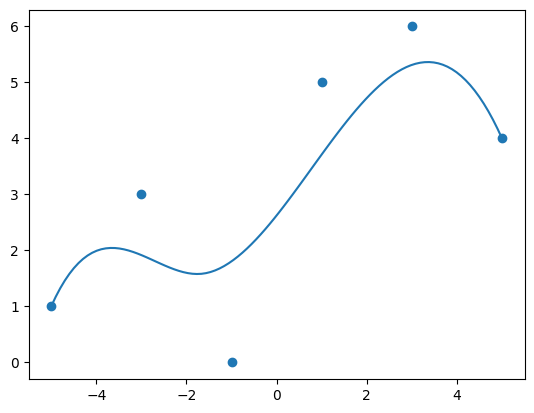

In [168]:
c = [1, 3, 0, 5, 6, 4]
k = 3

x = np.linspace(-5, 5, 100)
y = [F.bspline(i, c, (-5, 5), k) for i in x]

plt.scatter([i for i in np.linspace(-5, 5, len(c))], c) 
plt.plot(x, y)
plt.show()

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    <b>نمایش Basis functions </b><br>
   در بخش زیر Basis functions
    برای توابع B-spline
    با درجه 3 
    نمایش داده شده است.
    هر کدام از این توابع به نوعی نشان می‌دهند که در هر بازه مقدار تاثیر
    control point
    متناسب با آن تابع در مقدار نهایی تابع
    B-spline
    چقدر است.
</font>    
</p>


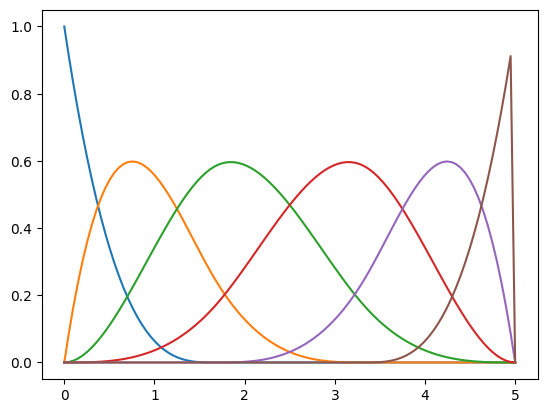

In [169]:
t = np.concatenate(([0] * k, np.linspace(0, len(c)-1, len(c)-k+1), [len(c)-1] * k))
x = np.linspace(0, len(c)-1 , 100)

for i in range(len(c)):
    y = [F.B(j, k, i, t) for j in x]
    plt.plot(x, y)

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    <b>کلاس Phi: </b><br>
این کلاس نشان دهنده توابع فعال سازی است که بر روی یال‌ها در مدل قرار دارند.
هنگام ساخت هر آبجکت از این کلاس باید تعداد 
control point ها
و بازه آن‌ها و درجه تابع 
B-spline
را مشخص کرد.
در ادامه مطابق با مقاله مقدار 
control point ها
را به صورت تصادفی از توزیع نرمال با میانگین صفر و واریانس 0.1 انتخاب می‌کنیم.
همچنین مقادیر
وزن 
b-spline
و 
bias
را نیز به صورت تصادفی انتخاب می‌کنیم.
این مقادیر در ادامه با استفاده از الگوریتم
Gradient Descent
لرن شده و به مقادیر بهینه نزدیک می‌شوند.
<br>
هنگام کال کردن تابع، ورودی داده شده به تابع
B-spline
و silu
داده می‌شود و مقدار خروجی تابع محاسبه می‌شود.
</font>    
</p>


In [170]:
class Phi:
    def __init__(self, num_c, range_c, k):
        self.num_c = num_c
        self.range_c = range_c
        self.k = k
        self.c = torch.normal(0, 0.1, (num_c, ), requires_grad=True, device=device)
        self.wb = torch.randn(1, requires_grad=True, device=device)
        self.ws = torch.randn(1, requires_grad=True, device=device)
        
    def parameters(self):
        return [self.c, self.wb, self.ws]
    
    def __call__(self, x):
        return self.wb * F.bspline(x, self.c, self.range_c, self.k) + self.ws * F.silu(x)
    
    def plot(self):
        x = np.linspace(self.range_c[0], self.range_c[1], 100)
        y = [self(torch.tensor(i)).detach().cpu().numpy() for i in x]
        plt.plot(x, y)
        plt.scatter([i for i in np.linspace(self.range_c[0], self.range_c[1], self.num_c)], self.c.detach().cpu().numpy(), color='red')
        plt.show()

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    <b>نمایش یک تابع Phi </b><br>
    در بخش زیر یک نمونه از تابع
    Phi
    با 10
    control point
    نمایش داده شده است.
    همانطور که می‌بینیم که مقادیر
    control point
    ها به صورت تصادفی انتخاب شده‌اند و نزدیک به صفر هستند.
    وجود بایاس در تابع نیز مشخص است زیرا با افزایش مقدار ورودی تابع، مقدار خروجی تابع افزایش می‌یابد.

</font>    
</p>


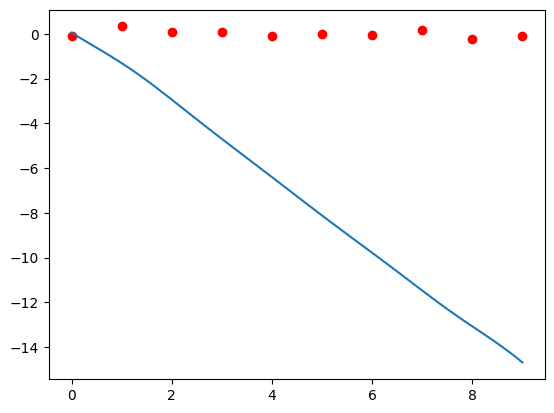

In [171]:
phi = Phi(10, (0, 9), 3)
phi.plot()

x = torch.tensor(5.0, dtype=torch.float32, requires_grad=True, device=device)
y = phi(x)

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    <b>کلاس Layer: </b><br>
این کلاس نشان دهنده لایه‌های مدل است. لایه‌ها مطابق با تعریف گفته شده در مقاله می‌باشد. هر لایه شامل تعدادی تابع
Phi
است به صورتی که از هر ورودی به لایه یک تابع به هر خروجی لایه باید وجود داشته باشد. بنابراین هر لایه شامل 
input_size * output_size
تابع
Phi
است.
<br>
هنگام forward کردن داده‌ها از لایه‌ها، داده‌ها از تمام توابع
Phi
لایه‌ها عبور می‌کنند و خروجی‌های تمام این توابع به صورت لیست به لایه بعدی منتقل می‌شوند.
</font>    
</p>


In [172]:
class Layer:
    def __init__(self, input_size, output_size, num_control_points, range_c, k):
        self.input_size = input_size
        self.output_size = output_size
        self.functions = [[Phi(num_control_points, range_c, k) for i in range(input_size)] for j in range(output_size)]
        
    def parameters(self):
        return [param for i in range(self.output_size) for j in range(self.input_size) for param in self.functions[i][j].parameters()]
    
    def forward(self, x):
        output = []
        for i in range(self.output_size):
            sum = 0
            for j in range(self.input_size):
                sum += self.functions[i][j](x[j])
            output.append(sum)
        return torch.stack(output)          
    
    def __call__(self, x):
        return self.forward(x)

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    <b>کلاس KAN: </b><br>
این کلاس نشان دهنده مدل KAN است. این مدل شامل تعدادی لایه است.
هنگام ساخت هر مدل باید ابعاد ورودی، ابعاد دیگر لایه‌ها، تعداد 
control point ها
و بازه آن‌ها و درجه توابع
B-spline
را مشخص کرد.
پس از آن با توجه به ابعاد لایه‌ها، لایه‌های مدل ساخته می‌شوند و در ادامه مورد استفاده قرار می‌گیرند.
<br>
هنگام 
forward
کردن داده‌ها از مدل، داده‌ها به ترتیب از لایه‌های مدل عبور می‌کنند و خروجی هر لایه به لایه بعد داده می‌شود و در نهایت مقدار خروجی برای داده‌های ورودی به دست خواهد آمد.
</font>    
</p>


In [173]:
class KAN(nn.Module):
    def __init__(self, input_size, layers, num_control_points, range_c, k):
        super(KAN, self).__init__()
        self.input_size = input_size
        layers = [input_size] + layers
        self.layers = [Layer(layers[i-1], layers[i], num_control_points, range_c, k) for i in range(1, len(layers))]
        
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]
    
    
    def forward(self, x):
        def single_forward(x):
            for layer in self.layers:
                x = layer(x)
            return x
        
        def batch_forward(x):
            return torch.stack([single_forward(i) for i in x]).squeeze(1)
        
        if len(x.shape) == 1:
            # x = x.clone().detach().requires_grad_(True)
            return single_forward(x)
        else:
            # x = x.clone().detach().requires_grad_(True)
            return batch_forward(x)
    
    
    def __call__(self, x):
        return self.forward(x)

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
در این بخش داده‌هایی برای تست کردن مدل ساخته شده است.
داده‌های ورودی به صورت 2 بعدی و در بازه -5 تا 5 قرار دارند و مقدار موردانتظار نیز مجموع سینوس ورودی اول و کوسینوس ورودی دوم می‌باشد.
<br>
در انتها نیز با کلاس 
MakeDataset
داده‌ها را به دیتاستی مناسب برای استفاده از 
DataLoader
پای تورچ تبدیل می‌کنیم.
</font>    
</p>


In [174]:
def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(-5, 5, 10)
y = np.linspace(-5, 5, 10)

X = [[x[i], y[j]] for i in range(len(x)) for j in range(len(y))]
X = np.array(X)
X_tensor = torch.tensor(X, dtype=torch.float32, requires_grad=True, device=device)
Y = torch.tensor(np.array([f(x, y) for x, y in X]), dtype=torch.float32).unsqueeze(1).to(device)

dataset = MakeDataset(X_tensor, Y)

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    <b> تعریف مدل: </b><br>
    در این بخش یک مدل ساده یک لایه با 2 ورودی و یک خروجی می‌سازیم.
    <br>
    همچنین یک بهینه ساز Adam
    را با نرخ یادگیری 0.02 و پارامترهای مدل تعریف می‌کنیم تا برای بهینه سازی مدل استفاده شود.
    <br>
    دیتالودر نیز با اندازه بچ 10 ساخته می‌شود.
</font>    
</p>


In [175]:
kan = KAN(2, [1], 6, (-5, 5), 3).to(device)
optimizer = torch.optim.Adam(kan.parameters(), lr=0.01)
data_loader = DataLoader(dataset, batch_size=10, shuffle=False)

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    <b>روند آموزش : </b><br>
در این بخش مدل را در 20 ایپاک آموزش می‌دهیم.
در هر ایپاک داده‌ها به صورت بچ به مدل داده می‌شود و خروجی مدل با خروجی مورد انتظار مقایسه می‌شود.
سپس خطای مدل محاسبه شده و با استفاده از بهینه ساز مدل به روزرسانی می‌شود.
در انتها نیز خطای مدل برای هر ایپاک چاپ می‌شود.

</font>    
</p>


In [182]:
for i in range(10):
    for idx, (x, y) in enumerate(data_loader):
        y_pred = kan(x)
        loss = F.mse(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx % 1 == 0:
            print(f'Epoch: {i+1}, Step: {idx}, Loss: {loss.item():.4f}')
    

Epoch: 1, Step: 0, Loss: 0.0696
Epoch: 1, Step: 1, Loss: 0.2190
Epoch: 1, Step: 2, Loss: 0.0504
Epoch: 1, Step: 3, Loss: 0.2972
Epoch: 1, Step: 4, Loss: 0.1148
Epoch: 1, Step: 5, Loss: 0.1487
Epoch: 1, Step: 6, Loss: 0.2498
Epoch: 1, Step: 7, Loss: 0.0461
Epoch: 1, Step: 8, Loss: 0.2023
Epoch: 1, Step: 9, Loss: 0.0575
Epoch: 2, Step: 0, Loss: 0.0711
Epoch: 2, Step: 1, Loss: 0.2094
Epoch: 2, Step: 2, Loss: 0.0488
Epoch: 2, Step: 3, Loss: 0.2859
Epoch: 2, Step: 4, Loss: 0.1121
Epoch: 2, Step: 5, Loss: 0.1397
Epoch: 2, Step: 6, Loss: 0.2304
Epoch: 2, Step: 7, Loss: 0.0447
Epoch: 2, Step: 8, Loss: 0.2002
Epoch: 2, Step: 9, Loss: 0.0584
Epoch: 3, Step: 0, Loss: 0.0694
Epoch: 3, Step: 1, Loss: 0.2065
Epoch: 3, Step: 2, Loss: 0.0465
Epoch: 3, Step: 3, Loss: 0.2685
Epoch: 3, Step: 4, Loss: 0.1056
Epoch: 3, Step: 5, Loss: 0.1369
Epoch: 3, Step: 6, Loss: 0.2212
Epoch: 3, Step: 7, Loss: 0.0434
Epoch: 3, Step: 8, Loss: 0.1911
Epoch: 3, Step: 9, Loss: 0.0606
Epoch: 4, Step: 0, Loss: 0.0670
Epoch: 4

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    <b>نمایش توابع قعال ساز مدل: </b><br>
انتظار داریم که تابع اول مشابه سینوس و تابع دوم مشابه کوسینوس باشد.
در بخش زیر توابع فعال سازی مدل برای داده‌های تست نمایش داده شده است.
همانطور که مشاهده می‌شود که توابع فعال سازی مدل با تقریب  مشابه توابع مورد انتظار هستند.
</font>    
</p>


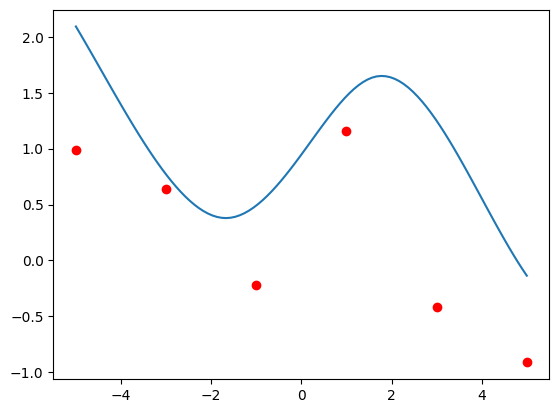

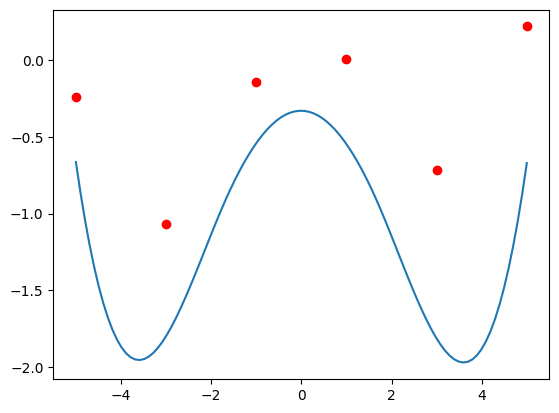

In [183]:
phi00 = kan.layers[0].functions[0][0]
phi01 = kan.layers[0].functions[0][1]

phi00.plot()
phi01.plot()

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    <b>نمایش خروجی مدل و خروجی واقعی : </b><br>
    در نمودار زیر صفحاتی که از خروجی مدل و خروجی واقعی برای داده‌های تست به دست آمده است نمایش داده شده است.
    همانطور که مشاهده می‌شود که خروجی مدل با خروجی مورد انتظار همپوشانی خوبی دارند.

</font>    
</p>


In [178]:
import plotly.graph_objects as go

x = np.linspace(-5, 5, 50)
y = np.linspace(-5, 5, 50)

X = [[x[i], y[j]] for i in range(len(x)) for j in range(len(y))]
X = np.array(X)
X_tensor = torch.tensor(X, dtype=torch.float32, requires_grad=True, device=device)
Y = torch.tensor(np.array([f(x, y) for x, y in X]), dtype=torch.float32).unsqueeze(1).to(device)

Y_pred = kan(X_tensor).detach().cpu().numpy()


In [179]:
fig = go.Figure(data=[
    go.Surface(x=x, y=y, z=Y.cpu().numpy().reshape(50, 50), name='real', colorscale='Reds'),
    go.Surface(x=x, y=y, z=Y_pred.reshape(50, 50), name='pred', colorscale='Blues')])

fig.show()